In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from category_encoders import BinaryEncoder
from geopy.geocoders import Nominatim
from geopy.distance import great_circle 

pd.set_option('display.max_column',None)
sns.set_theme(rc={"figure.figsize":(12,4)},font_scale=1.2)

In [124]:
# Read The Dataset
df = pd.read_csv("Airbnb_Open_Data.csv",low_memory=False)

In [125]:
# Display First 5 Rows
df.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,country code,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,US,False,strict,Private room,2020.0,$966,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,US,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,US,True,flexible,Private room,2005.0,$620,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,US,True,moderate,Entire home/apt,2005.0,$368,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,US,False,moderate,Entire home/apt,2009.0,$204,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [126]:
# Display General Information
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

In [127]:
# Display Summery Statistics For Numeric Columns
df.describe()

,id,host id,lat,long,Construction year,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,1.025990e+05,1.025990e+05,102591.000000,102591.000000,102385.000000,102190.000000,102416.000000,86720.000000,102273.000000,102280.000000,102151.000000
mean,2.914623e+07,4.925411e+10,40.728094,-73.949644,2012.487464,8.135845,27.483743,1.374022,3.279106,7.936605,141.133254
std,1.625751e+07,2.853900e+10,0.055857,0.049521,5.765556,30.553781,49.508954,1.746621,1.284657,32.218780,135.435024
min,1.001254e+06,1.236005e+08,40.499790,-74.249840,2003.000000,-1223.000000,0.000000,0.010000,1.000000,1.000000,-10.000000
25%,1.508581e+07,2.458333e+10,40.688740,-73.982580,2007.000000,2.000000,1.000000,0.220000,2.000000,1.000000,3.000000
50%,2.913660e+07,4.911774e+10,40.722290,-73.954440,2012.000000,3.000000,7.000000,0.740000,3.000000,1.000000,96.000000
75%,4.320120e+07,7.399650e+10,40.762760,-73.932350,2017.000000,5.000000,30.000000,2.000000,4.000000,2.000000,269.000000
max,5.736742e+07,9.876313e+10,40.916970,-73.705220,2022.000000,5645.000000,1024.000000,90.000000,5.000000,332.000000,3677.000000


## Illogical Data Based On Summary Statistics
 * minimum nights has a negative values.
 * availability 365 has a negative values.
 * minimum nights has an illogical outliers.
 * reviews per month has an illogical outliers.
 * calclated host listings count has an illogical outliers.
 * availability 365 has an illogical outliers.

In [128]:
# Edit The Negative Value of "minimum nights" , "availability 365" 
df['minimum nights'] = df['minimum nights'].apply(lambda x: abs(x))
df['availability 365'] = df['availability 365'].apply(lambda x: abs(x))

In [129]:
# Replace The Illogical Outliers With Nan
df.loc[df[df['minimum nights'] > 30].index,'minimum nights'] = np.nan
df.loc[df[df['reviews per month'] > 20].index,'reviews per month'] = np.nan
df.loc[df[df['calculated host listings count'] > 50].index,'calculated host listings count'] = np.nan
df.loc[df[df['availability 365'] > 365].index,'availability 365'] = np.nan

In [130]:
df.describe()

,id,host id,lat,long,Construction year,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,1.025990e+05,1.025990e+05,102591.000000,102591.000000,102385.000000,100488.000000,102416.000000,86700.000000,102273.000000,98629.000000,99369.000000
mean,2.914623e+07,4.925411e+10,40.728094,-73.949644,2012.487464,6.542323,27.483743,1.364798,3.279106,2.763518,134.023488
std,1.625751e+07,2.853900e+10,0.055857,0.049521,5.765556,9.355268,49.508954,1.607728,1.284657,5.509450,129.790457
min,1.001254e+06,1.236005e+08,40.499790,-74.249840,2003.000000,1.000000,0.000000,0.010000,1.000000,1.000000,0.000000
25%,1.508581e+07,2.458333e+10,40.688740,-73.982580,2007.000000,1.000000,1.000000,0.220000,2.000000,1.000000,2.000000
50%,2.913660e+07,4.911774e+10,40.722290,-73.954440,2012.000000,3.000000,7.000000,0.740000,3.000000,1.000000,90.000000
75%,4.320120e+07,7.399650e+10,40.762760,-73.932350,2017.000000,5.000000,30.000000,2.000000,4.000000,2.000000,253.000000
max,5.736742e+07,9.876313e+10,40.916970,-73.705220,2022.000000,30.000000,1024.000000,19.750000,5.000000,50.000000,365.000000


In [131]:
df.loc[df[df['availability 365'] == 0].index,'availability 365'] = np.nan

In [132]:
# Display Summery Statistics For Categorical Columns
df.describe(include='O')

,NAME,host_identity_verified,host name,neighbourhood group,neighbourhood,country,country code,instant_bookable,cancellation_policy,room type,price,service fee,last review,house_rules,license
count,102349,102310,102193,102570,102583,102067,102468,102494,102523,102599,102352,102326,86706,50468,2
unique,61281,2,13190,7,224,1,1,2,3,4,1151,231,2477,1976,1
top,Home away from home,unconfirmed,Michael,Manhattan,Bedford-Stuyvesant,United States,US,False,moderate,Entire home/apt,$206,$41,6/23/2019,#NAME?,41662/AL
freq,33,51200,881,43792,7937,102067,102468,51474,34343,53701,137,526,2443,2712,2


## Illogical Data Based On Summary Statistics
 * price has wrong dtype.
 * service fee has wrong dtype.
 * last review has wrong dtype.

In [133]:
def conver_to_numeric(x):
    try:
        return int(str(x).replace("$","").replace(",",""))
    except:
        return np.nan

In [134]:
df['price'] = df['price'].apply(conver_to_numeric)
df['service fee'] = df['service fee'].apply(conver_to_numeric)

In [135]:
df['last review'] = pd.to_datetime(df['last review'],errors='coerce')

In [136]:
df.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,country code,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,US,False,strict,Private room,2020.0,966.0,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,US,False,moderate,Entire home/apt,2007.0,142.0,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,US,True,flexible,Private room,2005.0,620.0,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,US,True,moderate,Entire home/apt,2005.0,368.0,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,US,False,moderate,Entire home/apt,2009.0,204.0,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [137]:
(df.isnull().sum() / df.shape[0]) * 100

id                                 0.000000
NAME                               0.243667
host id                            0.000000
host_identity_verified             0.281679
host name                          0.395715
neighbourhood group                0.028265
neighbourhood                      0.015595
lat                                0.007797
long                               0.007797
country                            0.518524
country code                       0.127682
instant_bookable                   0.102340
cancellation_policy                0.074075
room type                          0.000000
Construction year                  0.208579
price                              0.240743
service fee                        0.266084
minimum nights                     2.057525
number of reviews                  0.178364
last review                       15.490404
reviews per month                 15.496252
review rate number                 0.317742
calculated host listings count  

In [138]:
# Drop 'id','NAME','host id','country','country code' Because I Don't Need It
# Drop 'house_rules','license' Because It Have More Than 50% Nan Values
df.drop(['id','NAME','host id','country','country code','house_rules','license'],axis=1,inplace=True)

In [139]:
df.head()

,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365
0,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,966.0,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0
1,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,142.0,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0
2,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,True,flexible,Private room,2005.0,620.0,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0
3,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,368.0,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0
4,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,204.0,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0


In [140]:
# Count Of Duplicated Rows
df.duplicated().sum()

3641

In [141]:
# Drop Duplicates and Reset Index 
df.drop_duplicates(inplace=True,ignore_index=True)

In [142]:
df

,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365
0,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.0,966.0,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0
1,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,142.0,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0
2,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,True,flexible,Private room,2005.0,620.0,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0
3,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,368.0,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0
4,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,204.0,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98953,unconfirmed,Mariam,Brooklyn,Flatbush,40.64945,-73.96108,True,moderate,Private room,NaN,696.0,NaN,7.0,12.0,2019-03-27,0.44,5.0,1.0,NaN
98954,verified,Trey,Brooklyn,Bushwick,40.69872,-73.92718,False,flexible,Private room,NaN,909.0,NaN,1.0,19.0,2017-08-31,0.72,3.0,2.0,NaN
98955,verified,Michael,Brooklyn,Bedford-Stuyvesant,40.67810,-73.90822,True,moderate,Entire home/apt,NaN,387.0,NaN,2.0,50.0,2019-06-26,3.12,4.0,2.0,235.0
98956,unconfirmed,Shireen,Manhattan,Harlem,40.81248,-73.94317,True,strict,Private room,NaN,848.0,NaN,2.0,0.0,NaT,NaN,1.0,1.0,NaN


# Feature Engineering

In [143]:
def create_host_type(x):
    if x == 1:
        return 'Individual'
    elif x <= 5:
        return 'Small Business'
    else:
        return 'Large Business'

In [144]:
# We can categorize hosts based on the number of properties they have listed
df['host_type'] = df['calculated host listings count'].apply(create_host_type)

In [145]:
def review_activity(x):
    if x > 5:
        return 'Highly Active'
    elif x > 1:
        return 'Moderately Active'
    else:
        return 'Inactive'

In [146]:
# Property activity based on the number of monthly reviews
df['review_activity'] = df['reviews per month'].apply(review_activity)

In [147]:
# Percentage of available days throughout the year
df['availability_ratio'] = round((df['availability 365'] / 365) * 100,1)


In [148]:
# get the location of "Time Square, New York"
geolocator = Nominatim(user_agent="hazem")
location = geolocator.geocode("Time Square, New York")
location.raw

{'place_id': 336416831,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 304980452,
 'lat': '41.73835325',
 'lon': '-74.03694730280651',
 'class': 'building',
 'type': 'yes',
 'place_rank': 30,
 'importance': 5.233615625233871e-05,
 'addresstype': 'building',
 'name': 'Time Square',
 'display_name': 'Time Square, 652, NY 299, Ohioville, Town of New Paltz, Ulster County, New York, 12561, United States',
 'boundingbox': ['41.7382344', '41.7384706', '-74.0371548', '-74.0367398']}

In [149]:
# the lat and long for "Time Square, New York"
TS_location = (location.raw['lat'],location.raw['lon'])
TS_location

('41.73835325', '-74.03694730280651')

In [150]:
# Calculate the distance of each property from Time Square, New York
def get_the_mid_town_dist(x):
    try:
        x_location = (x['lat'],x['long'])
        dist = great_circle(x_location,TS_location).kilometers
        return dist
    except:
        return np.nan

In [151]:
# The distance of each property from the city center
df['Distance_to_midtown_km'] = df.apply(get_the_mid_town_dist,axis=1).round(2)

In [152]:
def classify_price(price):
    if price < 200:
        return 'Budget'
    elif price < 500:
        return 'Mid-Range'
    else:
        return 'Luxury'

In [153]:
# Classifying properties into categories based on price
df['price_category'] = df['price'].apply(classify_price)

In [154]:
# Drop this columns after feature engineering
df.drop(['lat', 'long','calculated host listings count','reviews per month','availability 365'],axis=1,inplace=True)

In [155]:
df.duplicated().sum()

0

# Univarite Analysis

<Axes: xlabel='host_identity_verified', ylabel='count'>

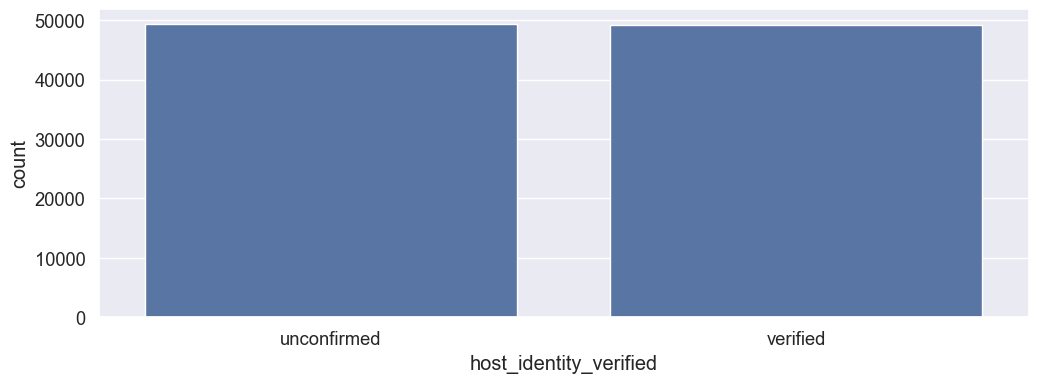

In [156]:
sns.countplot(x=df['host_identity_verified'])

<Axes: xlabel='neighbourhood group', ylabel='count'>

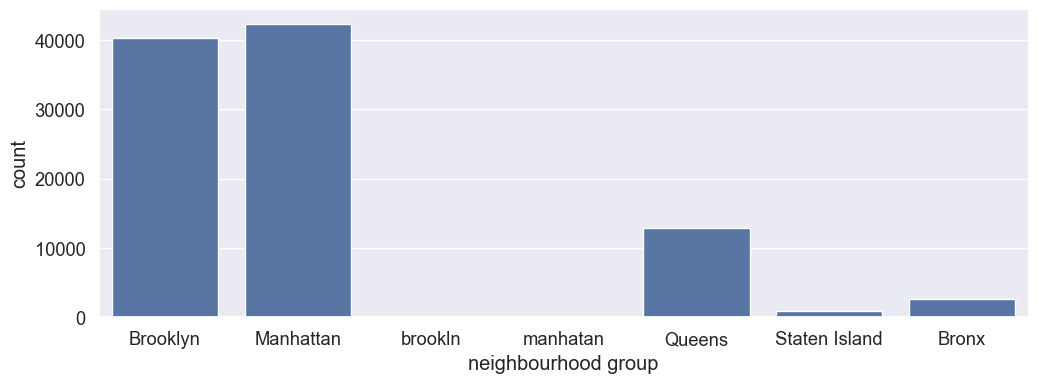

In [157]:
sns.countplot(x=df['neighbourhood group'])

In [158]:
# Correcting The Wrong Values
df['neighbourhood group'] = df['neighbourhood group'].replace('brookln','Brooklyn').replace('manhatan','Manhattan')

<Axes: xlabel='neighbourhood group', ylabel='count'>

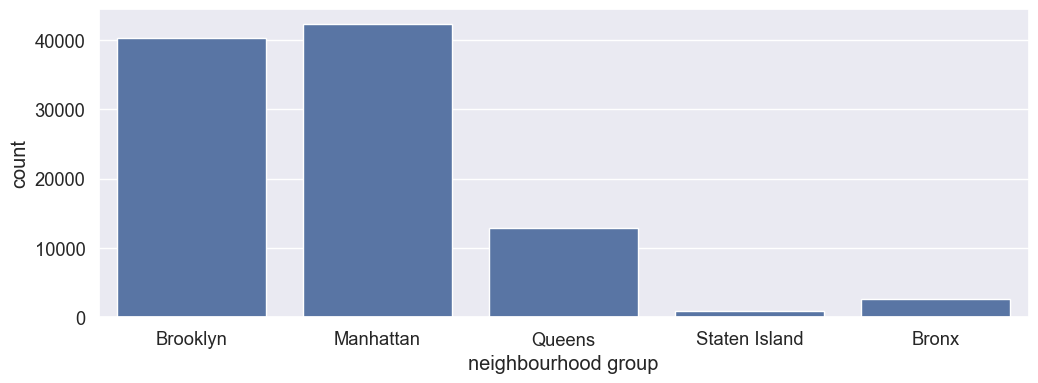

In [159]:
sns.countplot(x=df['neighbourhood group'])

In [160]:
top_40_neighbor = df['neighbourhood'].value_counts().sort_values(ascending=False).head(40).index

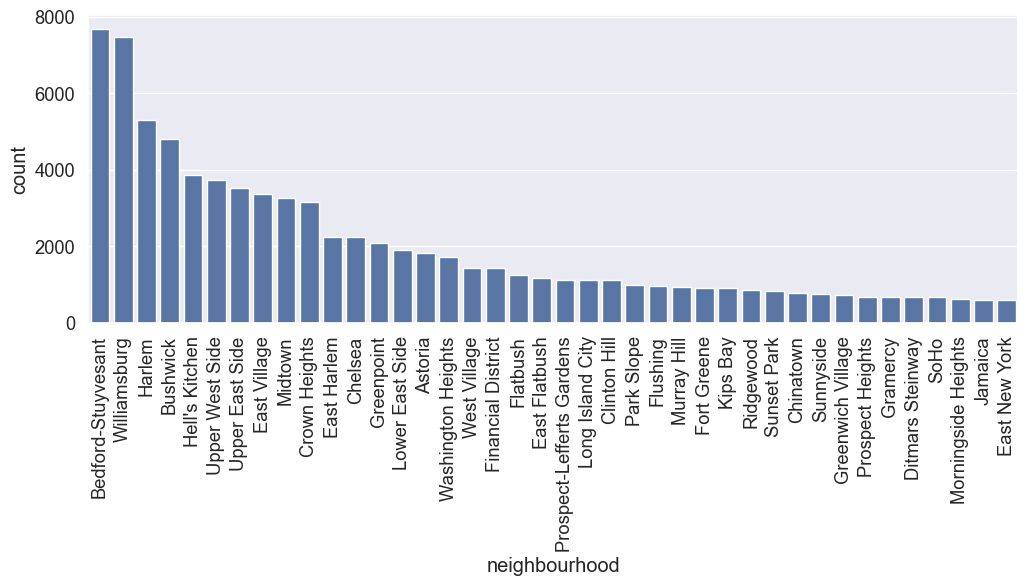

In [161]:
sns.countplot(x=df['neighbourhood'],order=top_40_neighbor).tick_params(axis='x',rotation=90)

<Axes: xlabel='instant_bookable', ylabel='count'>

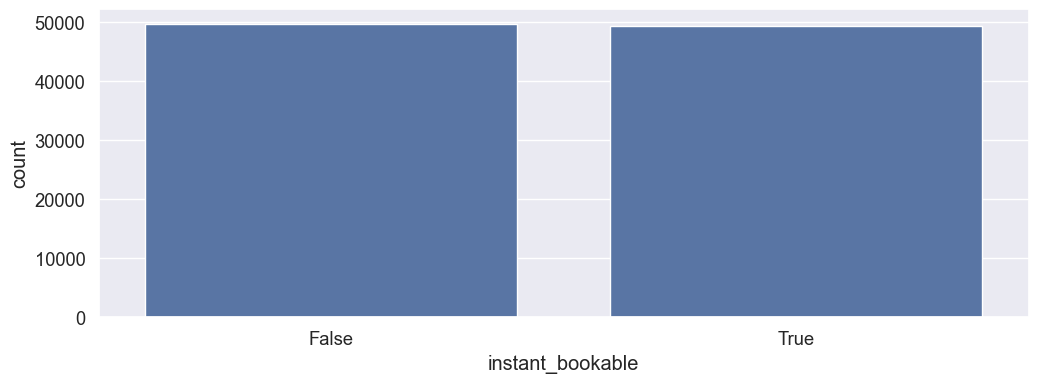

In [162]:
sns.countplot(x=df['instant_bookable'])

<Axes: xlabel='cancellation_policy', ylabel='count'>

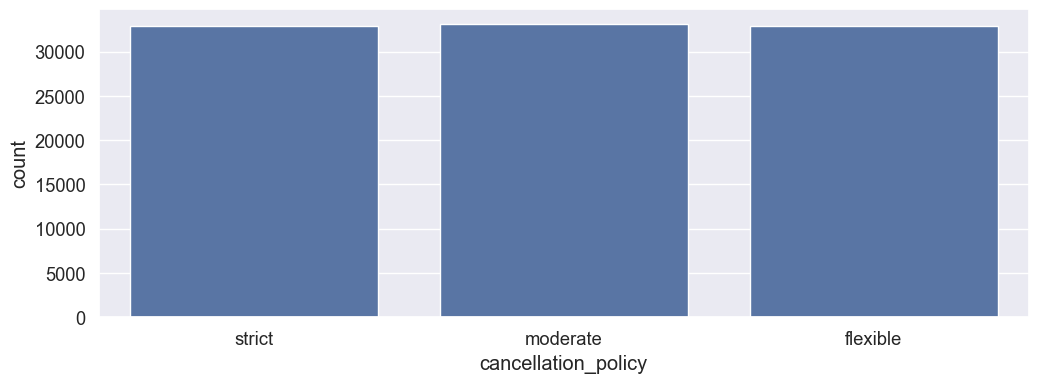

In [163]:
sns.countplot(x=df['cancellation_policy'])

<Axes: xlabel='room type', ylabel='count'>

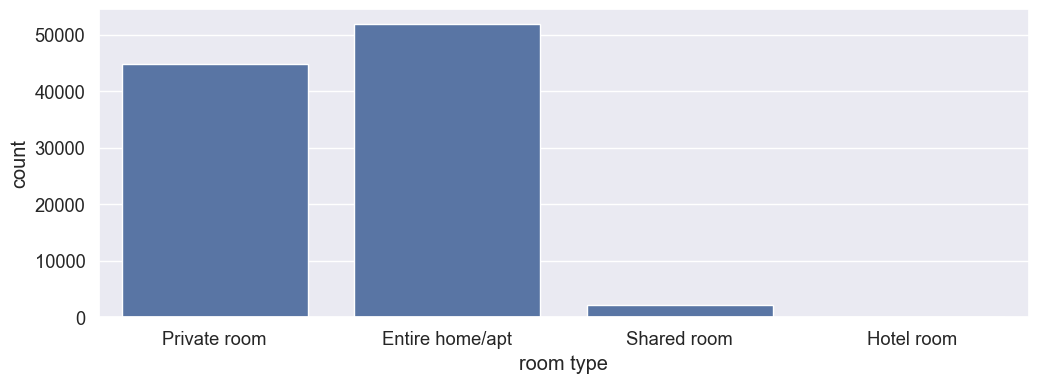

In [164]:
sns.countplot(x=df['room type'])

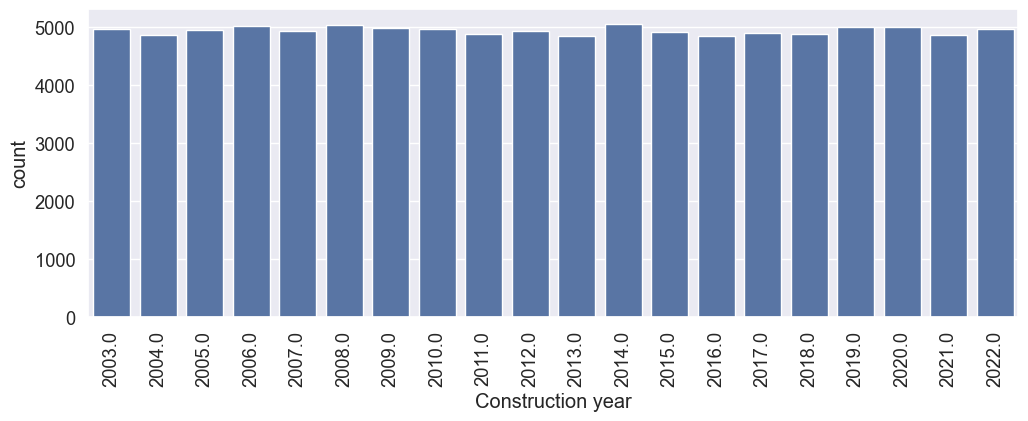

In [165]:
sns.countplot(x=df['Construction year']).tick_params(axis='x',rotation=90)

<Axes: xlabel='price'>

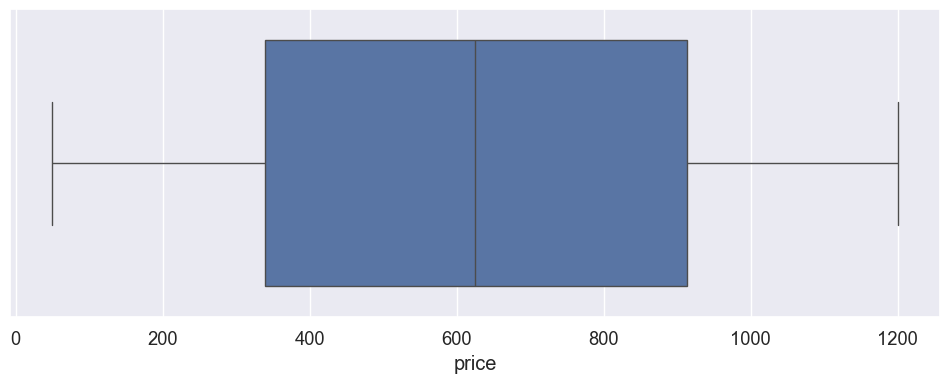

In [166]:
sns.boxplot(x=df['price'])

<Axes: xlabel='service fee'>

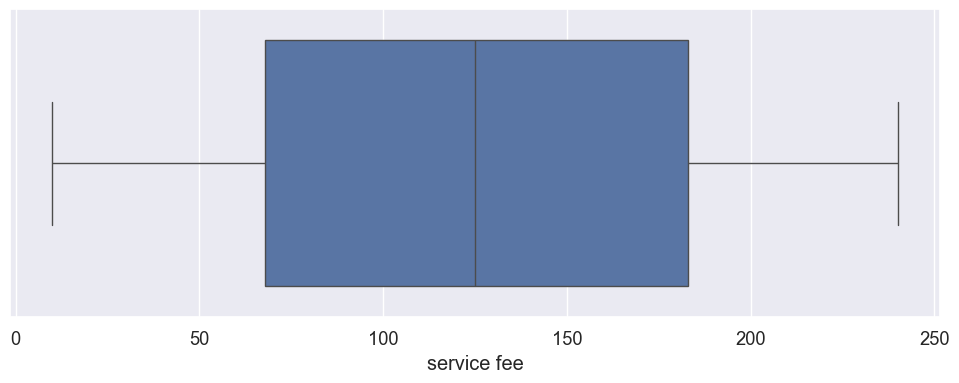

In [167]:
sns.boxplot(x=df['service fee'])

<Axes: xlabel='minimum nights'>

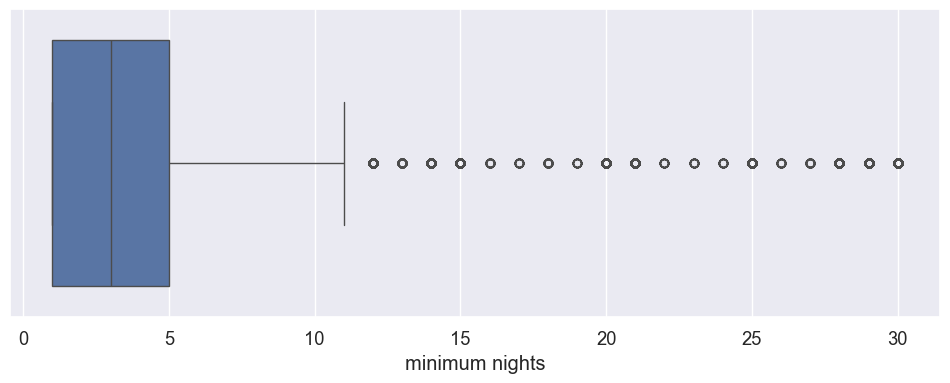

In [168]:
sns.boxplot(x=df['minimum nights'])

<Axes: xlabel='number of reviews'>

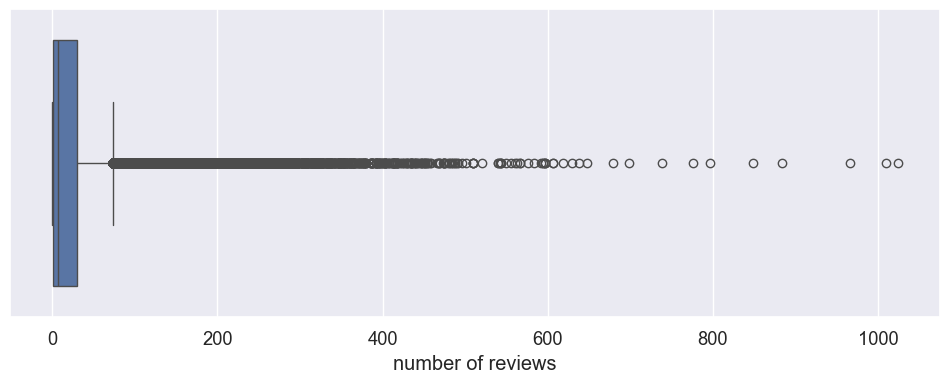

In [169]:
sns.boxplot(x=df['number of reviews'])

<Axes: xlabel='review rate number', ylabel='count'>

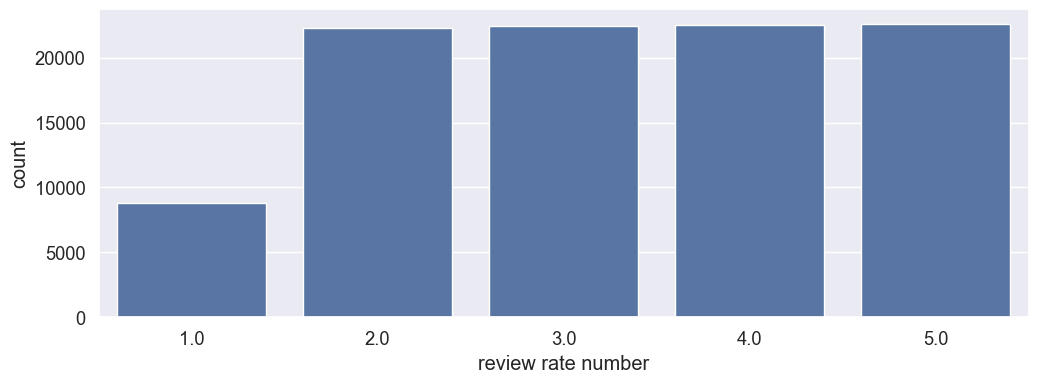

In [170]:
sns.countplot(x=df['review rate number'])

<Axes: xlabel='host_type', ylabel='count'>

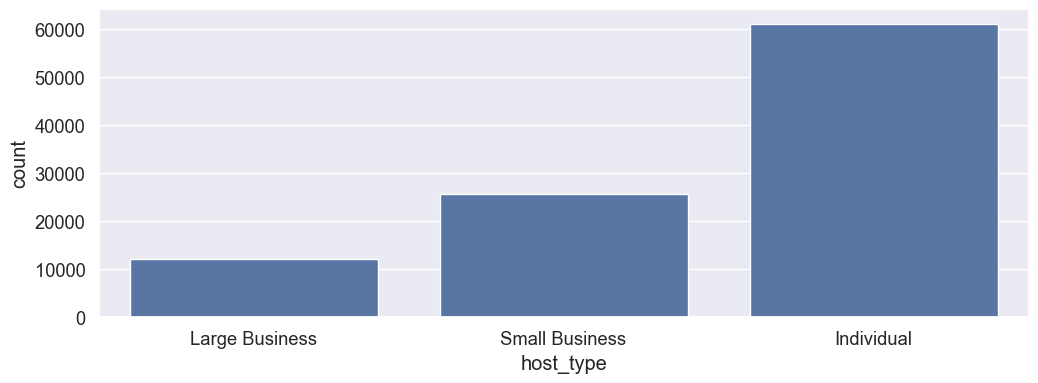

In [171]:
sns.countplot(x=df['host_type'])

<Axes: xlabel='review_activity', ylabel='count'>

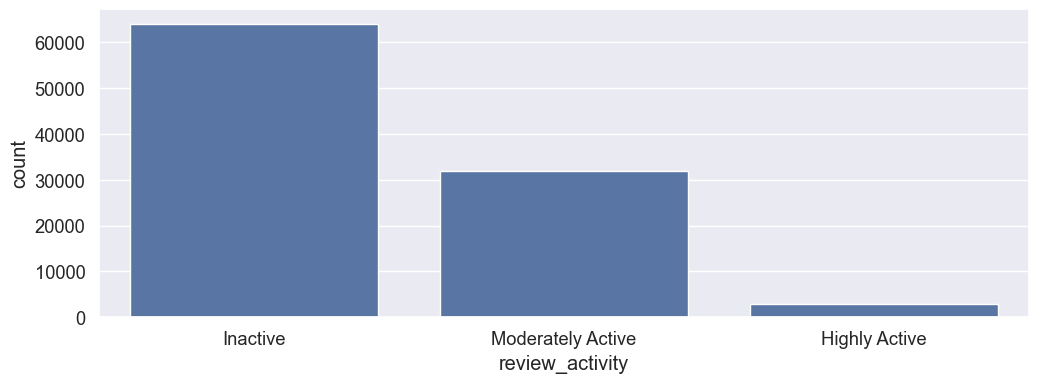

In [172]:
sns.countplot(x=df['review_activity'])

<Axes: xlabel='Distance_to_midtown_km'>

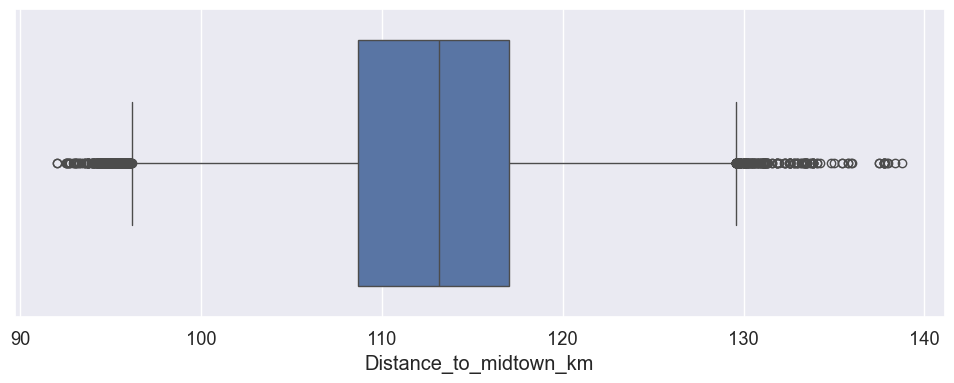

In [173]:
sns.boxplot(x=df['Distance_to_midtown_km'])

<Axes: xlabel='price_category', ylabel='count'>

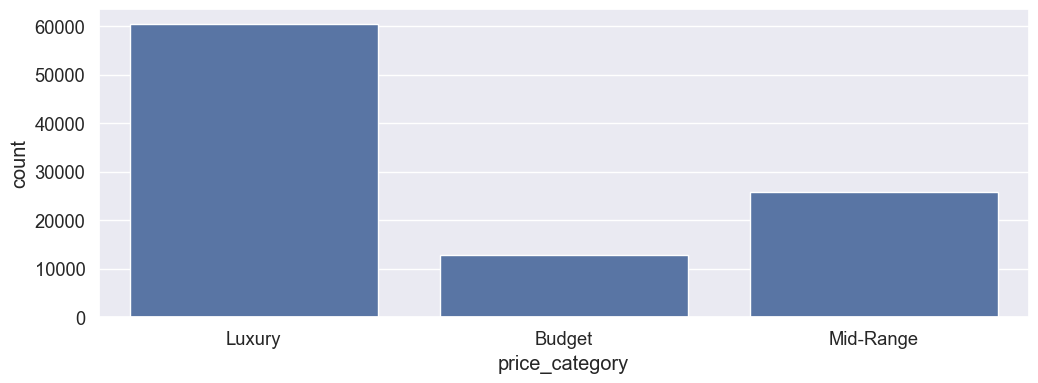

In [174]:
sns.countplot(x=df['price_category'])

# Bivariate Analysis

<Axes: xlabel='room type', ylabel='price'>

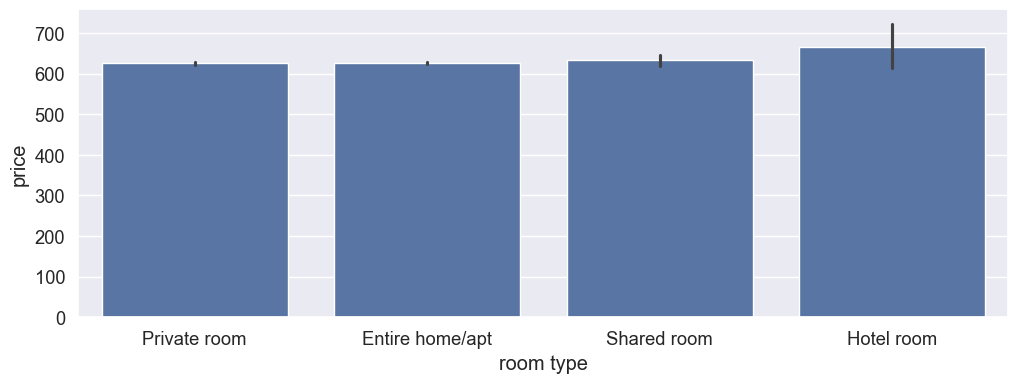

In [175]:
# Does the room type affect the price?
sns.barplot(x=df['room type'],y=df['price'])

<Axes: xlabel='host_type', ylabel='price'>

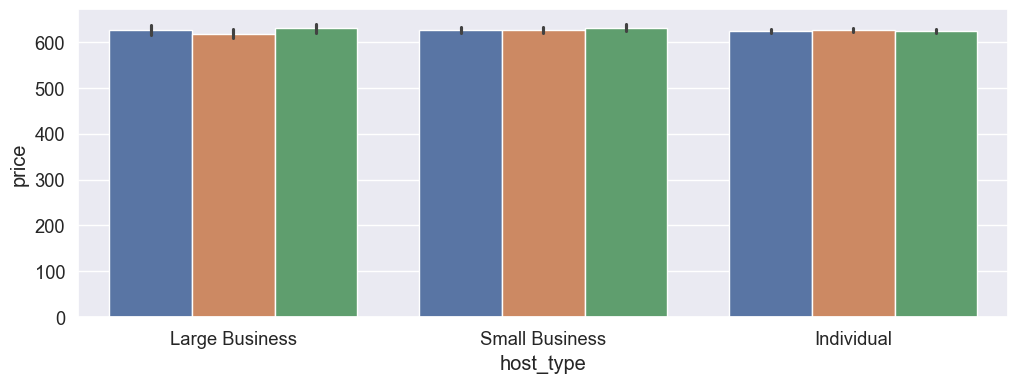

In [176]:
# Do cancellation policies and host type affect the price?
sns.barplot(x=df['host_type'],y=df['price'],hue=df['cancellation_policy'],legend=False)

<Axes: xlabel='neighbourhood group', ylabel='price'>

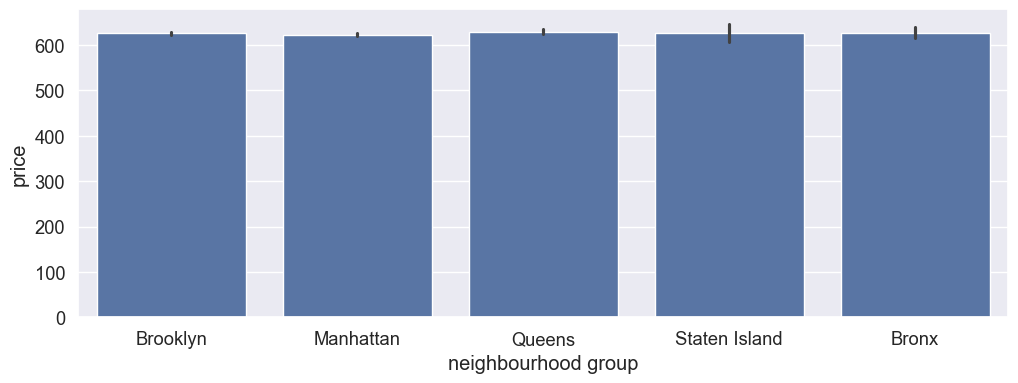

In [177]:
# Does neighbourhood group affect the price?
sns.barplot(x=df['neighbourhood group'],y=df['price'])

<Axes: xlabel='Distance_to_midtown_km', ylabel='price'>

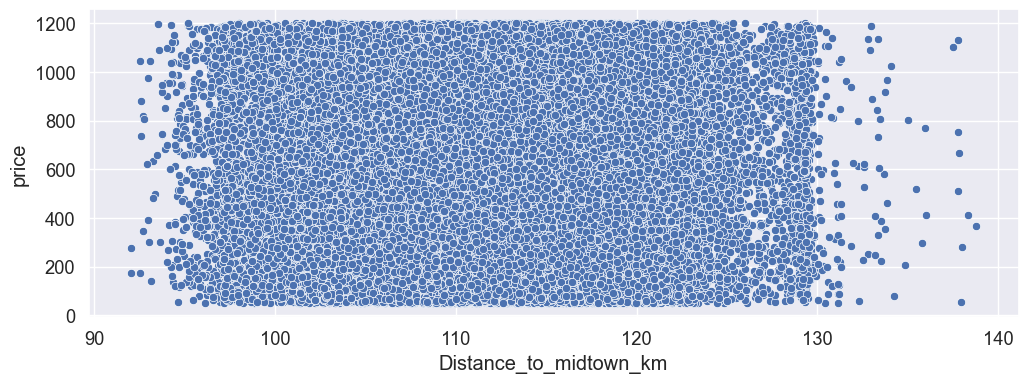

In [178]:
# Are properties near the city center more expensive?
sns.scatterplot(x=df['Distance_to_midtown_km'],y=df['price'])

<Axes: xlabel='review_activity', ylabel='price'>

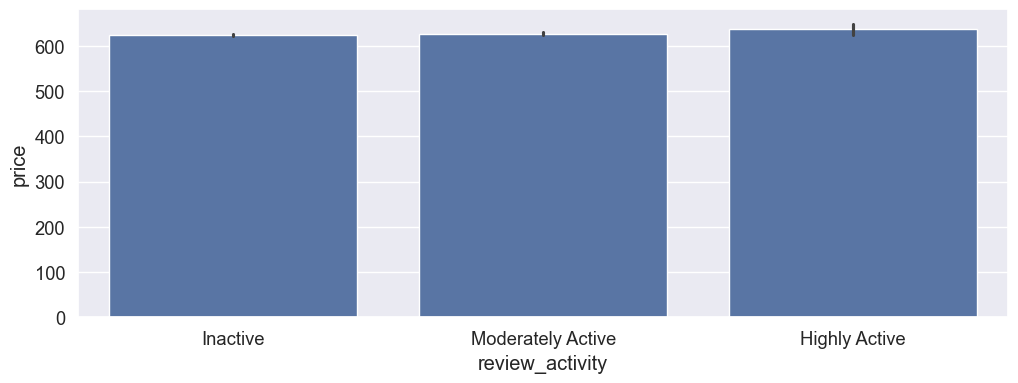

In [179]:
sns.barplot(x=df['review_activity'],y=df['price'])

<Axes: xlabel='availability_ratio', ylabel='price'>

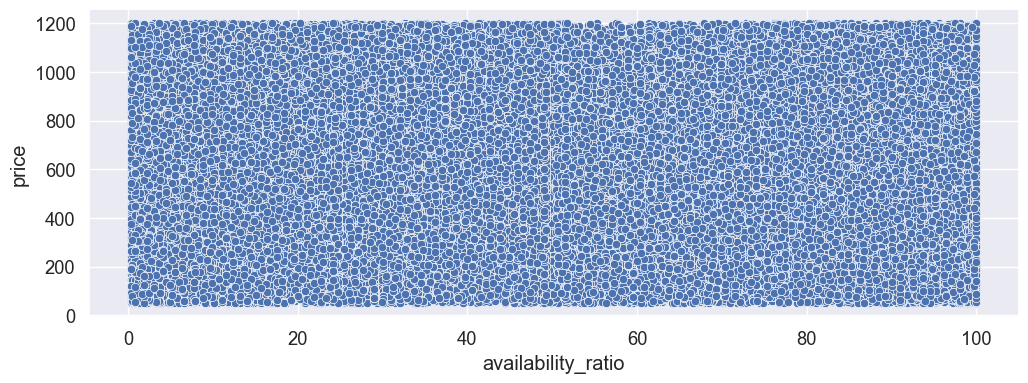

In [180]:
sns.scatterplot(x=df['availability_ratio'],y=df['price'])

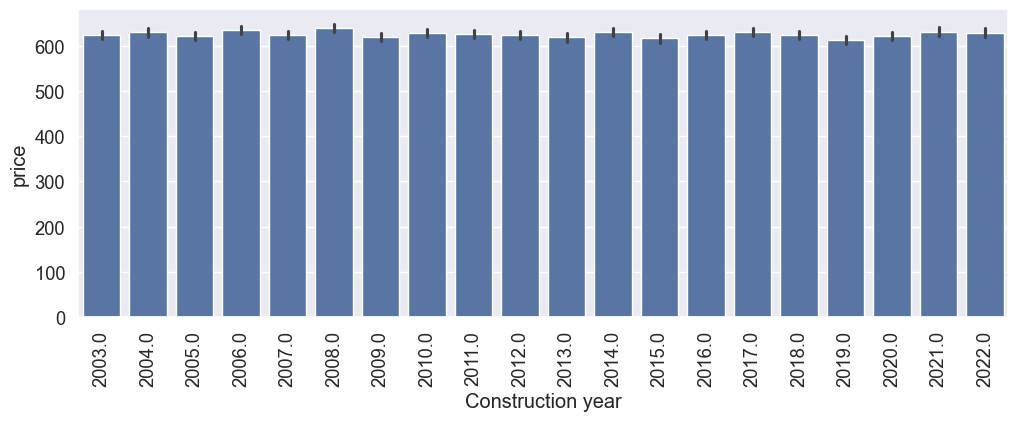

In [181]:
sns.barplot(x=df['Construction year'],y=df['price']).tick_params(axis='x',rotation=90)

<Axes: xlabel='number of reviews', ylabel='price'>

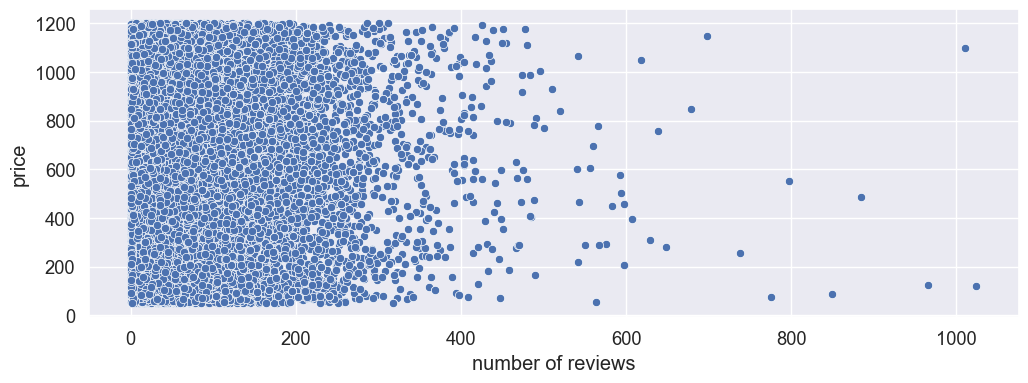

In [182]:
sns.scatterplot(x=df['number of reviews'],y=df['price'])

<Axes: xlabel='host_type', ylabel='count'>

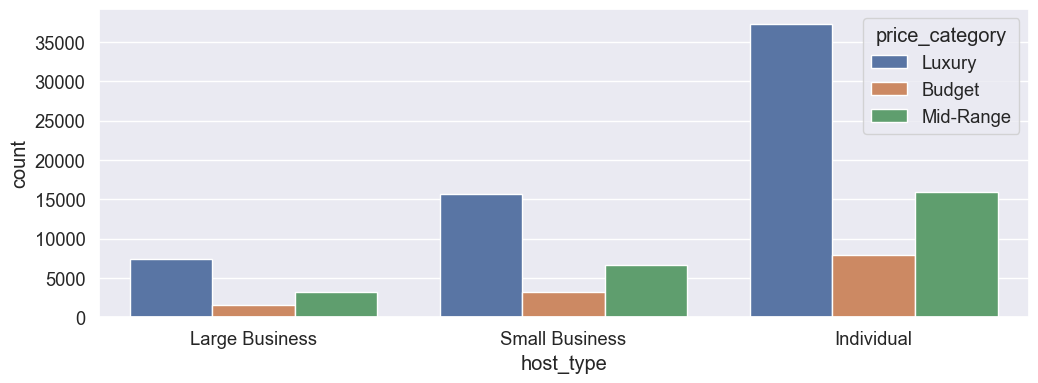

In [183]:
sns.countplot(x=df['host_type'],hue=df['price_category'])

# Preprocessing


In [184]:
df.head()

,host_identity_verified,host name,neighbourhood group,neighbourhood,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,review rate number,host_type,review_activity,availability_ratio,Distance_to_midtown_km,price_category
0,unconfirmed,Madaline,Brooklyn,Kensington,False,strict,Private room,2020.0,966.0,193.0,10.0,9.0,2021-10-19,4.0,Large Business,Inactive,78.4,121.42,Luxury
1,verified,Jenna,Manhattan,Midtown,False,moderate,Entire home/apt,2007.0,142.0,28.0,30.0,45.0,2022-05-21,4.0,Small Business,Inactive,62.5,109.59,Budget
2,NaN,Elise,Manhattan,Harlem,True,flexible,Private room,2005.0,620.0,124.0,3.0,0.0,NaT,5.0,Individual,Inactive,96.4,103.64,Luxury
3,unconfirmed,Garry,Brooklyn,Clinton Hill,True,moderate,Entire home/apt,2005.0,368.0,74.0,30.0,270.0,2019-07-05,4.0,Individual,Moderately Active,88.2,117.29,Mid-Range
4,verified,Lyndon,Manhattan,East Harlem,False,moderate,Entire home/apt,2009.0,204.0,41.0,10.0,9.0,2018-11-19,3.0,Individual,Inactive,79.2,104.79,Mid-Range


In [185]:
df.drop(['host name','last review'],axis=1,inplace=True)

In [186]:
df.duplicated().sum()

12

In [187]:
df.drop_duplicates(inplace=True,ignore_index=True)

In [188]:
df.isnull().sum()

host_identity_verified      289
neighbourhood group          29
neighbourhood                16
instant_bookable            105
cancellation_policy          76
room type                     0
Construction year           214
price                       247
service fee                 273
minimum nights             2041
number of reviews           180
review rate number          313
host_type                     0
review_activity               0
availability_ratio        25516
Distance_to_midtown_km        8
price_category                0
dtype: int64

In [189]:
cat_df = df.select_dtypes(include='O')
cat_df

,host_identity_verified,neighbourhood group,neighbourhood,instant_bookable,cancellation_policy,room type,host_type,review_activity,price_category
0,unconfirmed,Brooklyn,Kensington,False,strict,Private room,Large Business,Inactive,Luxury
1,verified,Manhattan,Midtown,False,moderate,Entire home/apt,Small Business,Inactive,Budget
2,NaN,Manhattan,Harlem,True,flexible,Private room,Individual,Inactive,Luxury
3,unconfirmed,Brooklyn,Clinton Hill,True,moderate,Entire home/apt,Individual,Moderately Active,Mid-Range
4,verified,Manhattan,East Harlem,False,moderate,Entire home/apt,Individual,Inactive,Mid-Range
...,...,...,...,...,...,...,...,...,...
98941,unconfirmed,Brooklyn,Flatbush,True,moderate,Private room,Individual,Inactive,Luxury
98942,verified,Brooklyn,Bushwick,False,flexible,Private room,Small Business,Inactive,Luxury
98943,verified,Brooklyn,Bedford-Stuyvesant,True,moderate,Entire home/apt,Small Business,Moderately Active,Mid-Range
98944,unconfirmed,Manhattan,Harlem,True,strict,Private room,Individual,Inactive,Luxury


In [190]:
num_df = df.select_dtypes(include='number')
num_df

,Construction year,price,service fee,minimum nights,number of reviews,review rate number,availability_ratio,Distance_to_midtown_km
0,2020.0,966.0,193.0,10.0,9.0,4.0,78.4,121.42
1,2007.0,142.0,28.0,30.0,45.0,4.0,62.5,109.59
2,2005.0,620.0,124.0,3.0,0.0,5.0,96.4,103.64
3,2005.0,368.0,74.0,30.0,270.0,4.0,88.2,117.29
4,2009.0,204.0,41.0,10.0,9.0,3.0,79.2,104.79
...,...,...,...,...,...,...,...,...
98941,NaN,696.0,NaN,7.0,12.0,5.0,NaN,121.25
98942,NaN,909.0,NaN,1.0,19.0,3.0,NaN,115.97
98943,NaN,387.0,NaN,2.0,50.0,4.0,64.4,118.39
98944,NaN,848.0,NaN,2.0,0.0,1.0,NaN,103.25


In [191]:
cat_df.isnull().sum()

host_identity_verified    289
neighbourhood group        29
neighbourhood              16
instant_bookable          105
cancellation_policy        76
room type                   0
host_type                   0
review_activity             0
price_category              0
dtype: int64

In [192]:
for col in cat_df.columns:
    cat_df[col].fillna(cat_df[col].mode()[0],inplace=True)

In [193]:
cat_df.isnull().sum()

host_identity_verified    0
neighbourhood group       0
neighbourhood             0
instant_bookable          0
cancellation_policy       0
room type                 0
host_type                 0
review_activity           0
price_category            0
dtype: int64

In [194]:
num_df.isnull().sum()

Construction year           214
price                       247
service fee                 273
minimum nights             2041
number of reviews           180
review rate number          313
availability_ratio        25516
Distance_to_midtown_km        8
dtype: int64

In [195]:
imputer = KNNImputer()

In [196]:
transformed = imputer.fit_transform(num_df)
transformed

array([[2.0200e+03, 9.6600e+02, 1.9300e+02, ..., 4.0000e+00, 7.8400e+01,
        1.2142e+02],
       [2.0070e+03, 1.4200e+02, 2.8000e+01, ..., 4.0000e+00, 6.2500e+01,
        1.0959e+02],
       [2.0050e+03, 6.2000e+02, 1.2400e+02, ..., 5.0000e+00, 9.6400e+01,
        1.0364e+02],
       ...,
       [2.0136e+03, 3.8700e+02, 8.3200e+01, ..., 4.0000e+00, 6.4400e+01,
        1.1839e+02],
       [2.0202e+03, 8.4800e+02, 1.3800e+02, ..., 1.0000e+00, 7.5560e+01,
        1.0325e+02],
       [2.0110e+03, 1.1280e+03, 2.2600e+02, ..., 4.0000e+00, 6.5200e+01,
        1.0315e+02]])

In [197]:
transformed_df = pd.DataFrame(transformed,columns=num_df.columns)
transformed_df

,Construction year,price,service fee,minimum nights,number of reviews,review rate number,availability_ratio,Distance_to_midtown_km
0,2020.0,966.0,193.0,10.0,9.0,4.0,78.40,121.42
1,2007.0,142.0,28.0,30.0,45.0,4.0,62.50,109.59
2,2005.0,620.0,124.0,3.0,0.0,5.0,96.40,103.64
3,2005.0,368.0,74.0,30.0,270.0,4.0,88.20,117.29
4,2009.0,204.0,41.0,10.0,9.0,3.0,79.20,104.79
...,...,...,...,...,...,...,...,...
98941,2018.4,696.0,139.2,7.0,12.0,5.0,53.54,121.25
98942,2011.8,909.0,152.4,1.0,19.0,3.0,29.10,115.97
98943,2013.6,387.0,83.2,2.0,50.0,4.0,64.40,118.39
98944,2020.2,848.0,138.0,2.0,0.0,1.0,75.56,103.25


In [198]:
df = pd.concat([cat_df,transformed_df],axis=1)
df

,host_identity_verified,neighbourhood group,neighbourhood,instant_bookable,cancellation_policy,room type,host_type,review_activity,price_category,Construction year,price,service fee,minimum nights,number of reviews,review rate number,availability_ratio,Distance_to_midtown_km
0,unconfirmed,Brooklyn,Kensington,False,strict,Private room,Large Business,Inactive,Luxury,2020.0,966.0,193.0,10.0,9.0,4.0,78.40,121.42
1,verified,Manhattan,Midtown,False,moderate,Entire home/apt,Small Business,Inactive,Budget,2007.0,142.0,28.0,30.0,45.0,4.0,62.50,109.59
2,unconfirmed,Manhattan,Harlem,True,flexible,Private room,Individual,Inactive,Luxury,2005.0,620.0,124.0,3.0,0.0,5.0,96.40,103.64
3,unconfirmed,Brooklyn,Clinton Hill,True,moderate,Entire home/apt,Individual,Moderately Active,Mid-Range,2005.0,368.0,74.0,30.0,270.0,4.0,88.20,117.29
4,verified,Manhattan,East Harlem,False,moderate,Entire home/apt,Individual,Inactive,Mid-Range,2009.0,204.0,41.0,10.0,9.0,3.0,79.20,104.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98941,unconfirmed,Brooklyn,Flatbush,True,moderate,Private room,Individual,Inactive,Luxury,2018.4,696.0,139.2,7.0,12.0,5.0,53.54,121.25
98942,verified,Brooklyn,Bushwick,False,flexible,Private room,Small Business,Inactive,Luxury,2011.8,909.0,152.4,1.0,19.0,3.0,29.10,115.97
98943,verified,Brooklyn,Bedford-Stuyvesant,True,moderate,Entire home/apt,Small Business,Moderately Active,Mid-Range,2013.6,387.0,83.2,2.0,50.0,4.0,64.40,118.39
98944,unconfirmed,Manhattan,Harlem,True,strict,Private room,Individual,Inactive,Luxury,2020.2,848.0,138.0,2.0,0.0,1.0,75.56,103.25


In [199]:
df.isnull().sum()

host_identity_verified    0
neighbourhood group       0
neighbourhood             0
instant_bookable          0
cancellation_policy       0
room type                 0
host_type                 0
review_activity           0
price_category            0
Construction year         0
price                     0
service fee               0
minimum nights            0
number of reviews         0
review rate number        0
availability_ratio        0
Distance_to_midtown_km    0
dtype: int64

In [200]:
df

,host_identity_verified,neighbourhood group,neighbourhood,instant_bookable,cancellation_policy,room type,host_type,review_activity,price_category,Construction year,price,service fee,minimum nights,number of reviews,review rate number,availability_ratio,Distance_to_midtown_km
0,unconfirmed,Brooklyn,Kensington,False,strict,Private room,Large Business,Inactive,Luxury,2020.0,966.0,193.0,10.0,9.0,4.0,78.40,121.42
1,verified,Manhattan,Midtown,False,moderate,Entire home/apt,Small Business,Inactive,Budget,2007.0,142.0,28.0,30.0,45.0,4.0,62.50,109.59
2,unconfirmed,Manhattan,Harlem,True,flexible,Private room,Individual,Inactive,Luxury,2005.0,620.0,124.0,3.0,0.0,5.0,96.40,103.64
3,unconfirmed,Brooklyn,Clinton Hill,True,moderate,Entire home/apt,Individual,Moderately Active,Mid-Range,2005.0,368.0,74.0,30.0,270.0,4.0,88.20,117.29
4,verified,Manhattan,East Harlem,False,moderate,Entire home/apt,Individual,Inactive,Mid-Range,2009.0,204.0,41.0,10.0,9.0,3.0,79.20,104.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98941,unconfirmed,Brooklyn,Flatbush,True,moderate,Private room,Individual,Inactive,Luxury,2018.4,696.0,139.2,7.0,12.0,5.0,53.54,121.25
98942,verified,Brooklyn,Bushwick,False,flexible,Private room,Small Business,Inactive,Luxury,2011.8,909.0,152.4,1.0,19.0,3.0,29.10,115.97
98943,verified,Brooklyn,Bedford-Stuyvesant,True,moderate,Entire home/apt,Small Business,Moderately Active,Mid-Range,2013.6,387.0,83.2,2.0,50.0,4.0,64.40,118.39
98944,unconfirmed,Manhattan,Harlem,True,strict,Private room,Individual,Inactive,Luxury,2020.2,848.0,138.0,2.0,0.0,1.0,75.56,103.25


In [201]:
x = df.drop('price',axis=1)
y = df['price']

In [202]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=1)

In [203]:
x_train.shape , y_train.shape

((79156, 16), (79156,))

In [204]:
x_test.shape , y_test.shape

((19790, 16), (19790,))

In [205]:
for i in x_train.select_dtypes(include='O').columns:
    print(i)
    print(cat_df[i].nunique())

host_identity_verified
2
neighbourhood group
5
neighbourhood
224
cancellation_policy
3
room type
4
host_type
3
review_activity
3
price_category
3


In [206]:
x_train.select_dtypes(include='bool')

,instant_bookable
68409,False
73836,False
32759,False
55685,True
44976,True
...,...
50057,True
98047,True
5192,False
77708,True


In [207]:
one_hot = OneHotEncoder(sparse_output=False,drop='first')
binary_enc = BinaryEncoder()

In [208]:
transform1 = one_hot.fit_transform(x_train[['host_identity_verified','cancellation_policy','room type','host_type','review_activity','price_category','instant_bookable']])
transform2 = binary_enc.fit_transform(x_train[['neighbourhood group','neighbourhood']])

In [209]:
transform1_df = pd.DataFrame(transform1,columns=one_hot.get_feature_names_out(),index=x_train.index)
transform2_df = pd.DataFrame(transform2,columns=binary_enc.get_feature_names_out(),index=x_train.index)

In [210]:
transform1_df

,host_identity_verified_verified,cancellation_policy_moderate,cancellation_policy_strict,room type_Hotel room,room type_Private room,room type_Shared room,host_type_Large Business,host_type_Small Business,review_activity_Inactive,review_activity_Moderately Active,price_category_Luxury,price_category_Mid-Range,instant_bookable_True
68409,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
73836,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
32759,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55685,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
44976,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
98047,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5192,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
77708,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0


In [211]:
transform2_df

,neighbourhood group_0,neighbourhood group_1,neighbourhood group_2,neighbourhood_0,neighbourhood_1,neighbourhood_2,neighbourhood_3,neighbourhood_4,neighbourhood_5,neighbourhood_6,neighbourhood_7
68409,0,0,1,0,0,0,0,0,0,0,1
73836,0,0,1,0,0,0,0,0,0,1,0
32759,0,1,0,0,0,0,0,0,0,1,1
55685,0,0,1,0,0,0,0,0,1,0,0
44976,0,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
50057,0,0,1,0,0,1,1,1,1,0,0
98047,0,1,0,0,0,0,1,0,0,0,1
5192,0,0,1,0,0,0,0,0,1,1,0
77708,0,0,1,0,0,0,0,0,1,1,0


In [212]:
x_train = pd.concat([x_train,transform1_df,transform2_df],axis=1)

In [213]:
x_train

,host_identity_verified,neighbourhood group,neighbourhood,instant_bookable,cancellation_policy,room type,host_type,review_activity,price_category,Construction year,service fee,minimum nights,number of reviews,review rate number,availability_ratio,Distance_to_midtown_km,host_identity_verified_verified,cancellation_policy_moderate,cancellation_policy_strict,room type_Hotel room,room type_Private room,room type_Shared room,host_type_Large Business,host_type_Small Business,review_activity_Inactive,review_activity_Moderately Active,price_category_Luxury,price_category_Mid-Range,instant_bookable_True,neighbourhood group_0,neighbourhood group_1,neighbourhood group_2,neighbourhood_0,neighbourhood_1,neighbourhood_2,neighbourhood_3,neighbourhood_4,neighbourhood_5,neighbourhood_6,neighbourhood_7
68409,unconfirmed,Manhattan,Chelsea,False,moderate,Entire home/apt,Individual,Moderately Active,Luxury,2018.0,152.0,1.0,102.0,4.0,9.00,110.59,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1
73836,verified,Manhattan,Harlem,False,strict,Entire home/apt,Individual,Inactive,Luxury,2022.0,216.0,7.0,1.0,2.0,6.60,101.52,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0
32759,unconfirmed,Brooklyn,Red Hook,False,moderate,Entire home/apt,Individual,Inactive,Budget,2022.0,11.0,2.0,10.0,2.0,94.50,118.48,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,1
55685,verified,Manhattan,SoHo,True,flexible,Private room,Large Business,Inactive,Mid-Range,2006.0,52.0,6.0,2.0,5.0,98.90,112.59,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,1,0,0,0,0,0,1,0,0
44976,unconfirmed,Manhattan,Theater District,True,flexible,Private room,Large Business,Inactive,Luxury,2020.0,100.0,1.0,0.0,5.0,82.50,109.33,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,unconfirmed,Manhattan,Chinatown,True,moderate,Entire home/apt,Small Business,Highly Active,Mid-Range,2017.0,68.0,4.0,55.0,4.0,66.80,113.70,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,1,0,0,1,1,1,1,0,0
98047,unconfirmed,Brooklyn,Bedford-Stuyvesant,True,moderate,Private room,Individual,Inactive,Luxury,2003.0,168.0,5.0,12.0,5.0,5.80,116.03,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,1,0,0,0,0,1,0,0,0,1
5192,verified,Manhattan,East Harlem,False,strict,Private room,Small Business,Inactive,Mid-Range,2014.0,50.0,7.0,47.0,2.0,3.00,105.30,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,1,1,0
77708,unconfirmed,Manhattan,East Harlem,True,flexible,Private room,Small Business,Moderately Active,Luxury,2006.0,214.0,1.0,148.0,3.0,12.60,104.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,1,1,0


In [214]:
x_train.drop(x_train.select_dtypes(include='O'),axis=1,inplace=True)
x_train.drop(x_train.select_dtypes(include='bool'),axis=1,inplace=True)

In [215]:
x_train

,Construction year,service fee,minimum nights,number of reviews,review rate number,availability_ratio,Distance_to_midtown_km,host_identity_verified_verified,cancellation_policy_moderate,cancellation_policy_strict,room type_Hotel room,room type_Private room,room type_Shared room,host_type_Large Business,host_type_Small Business,review_activity_Inactive,review_activity_Moderately Active,price_category_Luxury,price_category_Mid-Range,instant_bookable_True,neighbourhood group_0,neighbourhood group_1,neighbourhood group_2,neighbourhood_0,neighbourhood_1,neighbourhood_2,neighbourhood_3,neighbourhood_4,neighbourhood_5,neighbourhood_6,neighbourhood_7
68409,2018.0,152.0,1.0,102.0,4.0,9.00,110.59,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1
73836,2022.0,216.0,7.0,1.0,2.0,6.60,101.52,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0
32759,2022.0,11.0,2.0,10.0,2.0,94.50,118.48,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,1
55685,2006.0,52.0,6.0,2.0,5.0,98.90,112.59,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,1,0,0,0,0,0,1,0,0
44976,2020.0,100.0,1.0,0.0,5.0,82.50,109.33,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,2017.0,68.0,4.0,55.0,4.0,66.80,113.70,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,1,0,0,1,1,1,1,0,0
98047,2003.0,168.0,5.0,12.0,5.0,5.80,116.03,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,1,0,0,0,0,1,0,0,0,1
5192,2014.0,50.0,7.0,47.0,2.0,3.00,105.30,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,1,1,0
77708,2006.0,214.0,1.0,148.0,3.0,12.60,104.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,1,1,0


In [216]:
transform1 = one_hot.transform(x_test[['host_identity_verified','cancellation_policy','room type','host_type','review_activity','price_category','instant_bookable']])
transform2 = binary_enc.transform(x_test[['neighbourhood group','neighbourhood']])

In [217]:
transform1_df = pd.DataFrame(transform1,columns=one_hot.get_feature_names_out(),index=x_test.index)
transform2_df = pd.DataFrame(transform2,columns=binary_enc.get_feature_names_out(),index=x_test.index)

In [218]:
x_test = pd.concat([x_test,transform1_df,transform2_df],axis=1)

In [219]:
x_test.drop(x_test.select_dtypes(include='O'),axis=1,inplace=True)
x_test.drop(x_test.select_dtypes(include='bool'),axis=1,inplace=True)

In [220]:
x_test

,Construction year,service fee,minimum nights,number of reviews,review rate number,availability_ratio,Distance_to_midtown_km,host_identity_verified_verified,cancellation_policy_moderate,cancellation_policy_strict,room type_Hotel room,room type_Private room,room type_Shared room,host_type_Large Business,host_type_Small Business,review_activity_Inactive,review_activity_Moderately Active,price_category_Luxury,price_category_Mid-Range,instant_bookable_True,neighbourhood group_0,neighbourhood group_1,neighbourhood group_2,neighbourhood_0,neighbourhood_1,neighbourhood_2,neighbourhood_3,neighbourhood_4,neighbourhood_5,neighbourhood_6,neighbourhood_7
18875,2012.0,143.0,1.0,39.0,4.0,4.1,113.35,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,1,0,0,0,1,0,0,1,0,0
51272,2012.0,136.0,1.0,15.0,2.0,92.3,123.19,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0,0,1,1,0,0,1,0,1
906,2015.0,73.0,4.0,9.0,2.0,99.7,122.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0,0,0,1,0,0,1,1,1
98848,2018.0,195.0,30.0,2.0,5.0,59.2,104.77,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,1,0,0,0,1,0,1,0,0
58186,2007.0,73.0,6.0,163.0,2.0,21.9,110.04,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47093,2009.0,197.0,5.0,4.0,3.0,78.1,103.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,1,1,0
69656,2015.0,12.0,4.0,72.0,4.0,33.4,111.08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,1,0,1,0,1,0,0
35713,2014.0,229.0,2.0,9.0,2.0,44.7,109.54,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0,1,1,0,0,0,1,1,1,1,1
27323,2009.0,219.0,2.0,15.0,5.0,1.1,117.36,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1


In [221]:
scaler = RobustScaler() 

In [222]:
cols = ['Construction year','service fee','minimum nights','number of reviews','availability_ratio','Distance_to_midtown_km']

In [223]:
x_train[cols] = scaler.fit_transform(x_train[cols])
x_test[cols] = scaler.transform(x_test[cols])

In [224]:
x_train

,Construction year,service fee,minimum nights,number of reviews,review rate number,availability_ratio,Distance_to_midtown_km,host_identity_verified_verified,cancellation_policy_moderate,cancellation_policy_strict,room type_Hotel room,room type_Private room,room type_Shared room,host_type_Large Business,host_type_Small Business,review_activity_Inactive,review_activity_Moderately Active,price_category_Luxury,price_category_Mid-Range,instant_bookable_True,neighbourhood group_0,neighbourhood group_1,neighbourhood group_2,neighbourhood_0,neighbourhood_1,neighbourhood_2,neighbourhood_3,neighbourhood_4,neighbourhood_5,neighbourhood_6,neighbourhood_7
68409,0.6,0.236842,-0.666667,3.275862,4.0,-0.741846,-0.301796,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1
73836,1.0,0.798246,1.333333,-0.206897,2.0,-0.789578,-1.388024,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0
32759,1.0,-1.000000,-0.333333,0.103448,2.0,0.958632,0.643114,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,1
55685,-0.6,-0.640351,1.000000,-0.172414,5.0,1.046142,-0.062275,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,1,0,0,0,0,0,1,0,0
44976,0.8,-0.219298,-0.666667,-0.241379,5.0,0.719968,-0.452695,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50057,0.5,-0.500000,0.333333,1.655172,4.0,0.407717,0.070659,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,1,0,0,1,1,1,1,0,0
98047,-0.9,0.377193,0.666667,0.172414,5.0,-0.805489,0.349701,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,1,0,0,0,0,1,0,0,0,1
5192,0.2,-0.657895,1.333333,1.379310,2.0,-0.861177,-0.935329,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,0,1,0,0,0,0,0,1,1,0
77708,-0.6,0.780702,-0.666667,4.862069,3.0,-0.670247,-0.972455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,1,1,0


In [225]:
x_test

,Construction year,service fee,minimum nights,number of reviews,review rate number,availability_ratio,Distance_to_midtown_km,host_identity_verified_verified,cancellation_policy_moderate,cancellation_policy_strict,room type_Hotel room,room type_Private room,room type_Shared room,host_type_Large Business,host_type_Small Business,review_activity_Inactive,review_activity_Moderately Active,price_category_Luxury,price_category_Mid-Range,instant_bookable_True,neighbourhood group_0,neighbourhood group_1,neighbourhood group_2,neighbourhood_0,neighbourhood_1,neighbourhood_2,neighbourhood_3,neighbourhood_4,neighbourhood_5,neighbourhood_6,neighbourhood_7
18875,0.0,0.157895,-0.666667,1.103448,4.0,-0.839300,0.028743,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,1,0,0,0,1,0,0,1,0,0
51272,0.0,0.096491,-0.666667,0.275862,2.0,0.914877,1.207186,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0,0,0,1,1,0,0,1,0,1
906,0.3,-0.456140,0.333333,0.068966,2.0,1.062053,1.154491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0,0,0,1,0,0,1,1,1
98848,0.6,0.614035,9.000000,-0.172414,5.0,0.256563,-0.998802,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,1,0,0,0,1,0,1,0,0
58186,-0.5,-0.456140,1.000000,5.379310,2.0,-0.485282,-0.367665,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,0,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47093,-0.3,0.631579,0.666667,-0.103448,3.0,0.632458,-1.123353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,1,1,0
69656,0.3,-0.991228,0.333333,2.241379,4.0,-0.256563,-0.243114,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0,1,0,1,0,1,0,0
35713,0.2,0.912281,-0.333333,0.068966,2.0,-0.031822,-0.427545,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0,1,1,0,0,0,1,1,1,1,1
27323,-0.3,0.824561,-0.333333,0.275862,5.0,-0.898966,0.508982,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,1
